<a href="https://colab.research.google.com/github/Wilbur0912/comp551/blob/main/assignment3_ipynb_correct_11_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task1

In [ ]:
!pip install medmnist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

Normalize and flatten data

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
from medmnist import OrganAMNIST
train_dataset = OrganAMNIST(split="train",download=True, transform=transform)
val_dataset = OrganAMNIST(split="val",download=True, transform=transform)
test_dataset = OrganAMNIST(split="test",download=True, transform=transform)

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [ ]:
# Load datasets
X_train = np.array([train_dataset[i][0].flatten().numpy() for i in range(len(train_dataset))])
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

X_test = np.array([test_dataset[i][0].flatten().numpy() for i in range(len(test_dataset))])
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

# One-hot encode labels
num_classes = 11  # Number of classes in OrganAMNIST
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]


In [ ]:
print(f"{len(train_dataset)=}")
print(f"{len(test_dataset)=}")

# img, label = train_dataset[0]
img = train_dataset[0][0]
label = train_dataset[0][1]

img.shape

flattened_img = img.flatten()
flattened_img.shape

len(train_dataset)=34561
len(test_dataset)=17778


torch.Size([784])

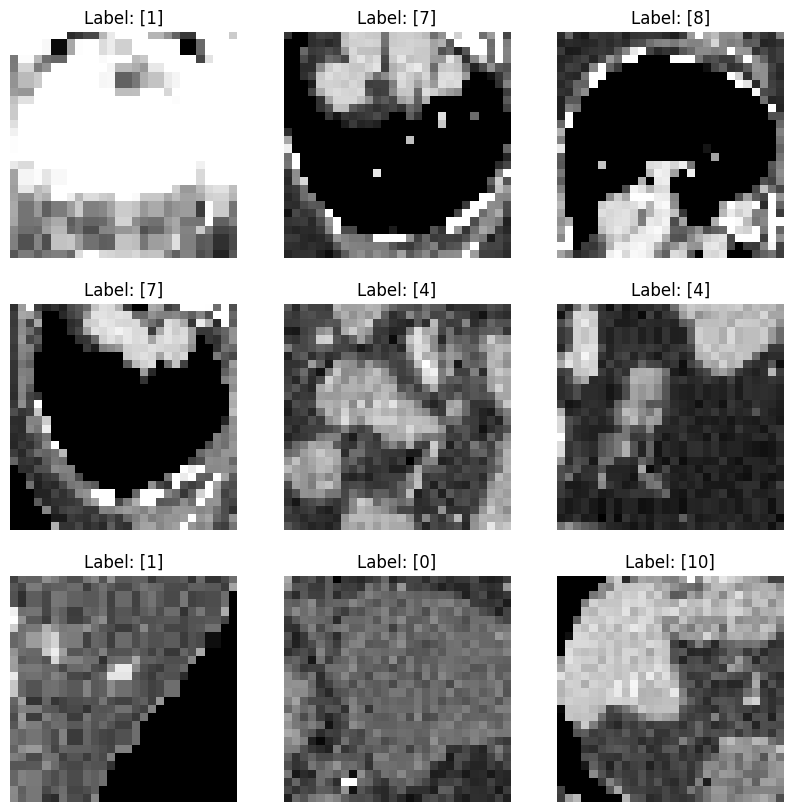

In [ ]:
sample_img_idx = np.random.randint(0, len(train_dataset), 9)
plt.figure(figsize=(10, 10))
for i, j in enumerate(sample_img_idx):
  image, label = train_dataset[j]
  plt.subplot(3, 3, i+1)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(f"Label: {label}")
  plt.axis("off")

# Task2

In [ ]:
import numpy as np

class NeuralNetwork:
  def __init__(self, input_size, hidden_size, output_size, activation_func, hidden_layers_num):
    self.activation_func = activation_func
    self.hidden_layers_num = hidden_layers_num
    self.cache = {}
    self.lambda_l2 = 0

    if self.hidden_layers_num == 0:
        # Initialize output layer weights directly for no hidden layers
        self.weights_hidden_output = np.random.randn(input_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))
    else:
        # Initialize weights for hidden layers and output layer
        self.weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
        self.bias_output = np.zeros((1, output_size))
        self.hidden_layers = []
        self.hidden_layers.append((np.random.randn(input_size, hidden_size) * 0.01, np.zeros((1, hidden_size))))
        for _ in range(hidden_layers_num - 1):
            self.hidden_layers.append((np.random.randn(hidden_size, hidden_size) * 0.01, np.zeros((1, hidden_size))))


  def activation_func_method(self, x):
    if self.activation_func == "relu":
      return np.maximum(0, x)
    elif self.activation_func == "tanh":
      return np.tanh(x)
    elif self.activation_func == "leaky_relu":
      return np.maximum(0.01 * x, x)
    elif self.activation_func == "sigmoid":
      return 1 / (1 + np.exp(-x))
    else:
      raise ValueError("Invalid activation function")
  # def softmax(self, x):
  #   exp_x = np.exp(x - np.max(x))
  #   #exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
  #   return exp_x / exp_x.sum(axis=1, keepdims=True)
  def softmax(self, x):
    # Subtract the maximum value in each row for numerical stability
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

  def forward(self, X):
    """
    Forward propagation for the neural network.
    X: Input data of shape (batch_size, input_size).
    """
    self.cache = {}  # Clear cache for the current pass
    if self.hidden_layers_num == 0:
        # No hidden layers, directly compute output
        self.final_input = np.dot(X, self.weights_hidden_output) + self.bias_output
        self.final_output = self.softmax(self.final_input)
        #print(f"Final output shape (no hidden layers): {self.final_output.shape}")
        return self.final_output
    else:
        # With hidden layers
        hidden_out = X
        for i, (weights, bias) in enumerate(self.hidden_layers, start=1):
            Z = np.dot(hidden_out, weights) + bias
            self.cache[f"Z{i}"] = Z  # Pre-activation values
            A = self.activation_func_method(Z)
            self.cache[f"A{i}"] = A  # Post-activation values
            hidden_out = A

        # Output layer
        self.final_input = np.dot(hidden_out, self.weights_hidden_output) + self.bias_output
        self.final_output = self.softmax(self.final_input)
        #print(f"Final output shape (with hidden layers): {self.final_output.shape}")
        return self.final_output



  def activation_func_derivative(self, x):
    if self.activation_func == "relu":
        return (x > 0).astype(float)
    elif self.activation_func == "sigmoid":
        return x * (1 - x)
    elif self.activation_func == "tanh":
        return 1 - np.tanh(x)**2
    elif self.activation_func == "leaky_relu":
        grad = np.ones_like(x)
        grad[x < 0] = 0.01  # Slope = 0.01 for x < 0
        return grad
    else:
        raise ValueError("Invalid activation function")

  def backward(self, X, y, learning_rat, lambda_l1, lambda_l2):
    """
    Backward propagation for the neural network.
    X: Input data of shape (batch_size, input_size).
    y: One-hot encoded labels of shape (batch_size, output_size).
    learning_rate: Learning rate for gradient descent.
    """
    gradients = {}
    m = X.shape[0]  # Number of samples in the batch

    # Compute dZ for the output layer
    dZ = self.final_output - y  # Shape: (batch_size, output_size)
    #print(f"dZ initial shape: {dZ.shape}")
    if dZ.ndim > 2:
        dZ = dZ.reshape(m, -1)  # Ensure it has shape (batch_size, output_size)
    #print(f"dZ corrected shape: {dZ.shape}")

    # Gradients for output layer
    A_prev = self.cache[f"A{self.hidden_layers_num}"] if self.hidden_layers_num > 0 else X
    #print(f"A_prev shape: {A_prev.shape}")

    gradients[f"dW{self.hidden_layers_num + 1}"] = (1 / m) * np.dot(A_prev.T, dZ)  # Shape: (hidden_size or input_size, output_size)
    gradients[f"db{self.hidden_layers_num + 1}"] = (1 / m) * np.sum(dZ, axis=0, keepdims=True)  # Shape: (1, output_size)
    #print(f"Gradient dW shape (output layer): {gradients[f'dW{self.hidden_layers_num + 1}'].shape}")
    #print(f"Gradient db shape (output layer): {gradients[f'db{self.hidden_layers_num + 1}'].shape}")

    # Clip gradients for output layer
    max_grad = 1.0  # Gradient clipping threshold
    gradients[f"dW{self.hidden_layers_num + 1}"] = np.clip(gradients[f"dW{self.hidden_layers_num + 1}"], -max_grad, max_grad)
    gradients[f"db{self.hidden_layers_num + 1}"] = np.clip(gradients[f"db{self.hidden_layers_num + 1}"], -max_grad, max_grad)


    # Update weights and biases for the output layer
    self.weights_hidden_output -= learning_rate * gradients[f"dW{self.hidden_layers_num + 1}"]
    self.bias_output -= learning_rate * gradients[f"db{self.hidden_layers_num + 1}"]

    # Backpropagate through hidden layers (if any)
    for i in range(self.hidden_layers_num, 0, -1):
        dA = np.dot(dZ, self.weights_hidden_output.T) if i == self.hidden_layers_num else np.dot(dZ, self.hidden_layers[i][0].T)
        dZ = dA * self.activation_func_derivative(self.cache[f"Z{i}"])  # Activation derivative
        A_prev = self.cache[f"A{i - 1}"] if i > 1 else X  # Use input X for the first hidden layer
        l1_grad = lambda_l1 * np.sign(self.hidden_layers[i - 1][0])
        l2_grad = lambda_l2 * self.hidden_layers[i - 1][0]
        gradients[f"dW{i}"] = (1 / m) * np.dot(A_prev.T, dZ) + l1_grad + l2_grad
        gradients[f"db{i}"] = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

        #print(f"Gradient dW shape (hidden layer {i}): {gradients[f'dW{i}'].shape}")
        #print(f"Gradient db shape (hidden layer {i}): {gradients[f'db{i}'].shape}")

        # Update weights and biases for hidden layers
        self.hidden_layers[i - 1] = (
            self.hidden_layers[i - 1][0] - learning_rate * gradients[f"dW{i}"],
            self.hidden_layers[i - 1][1] - learning_rate * gradients[f"db{i}"],
        )




  def fit(self, X, X_val, y, y_val, epochs, batch_size, learning_rate, lambda_l2 = 0, lambda_l1 = 0):
    """
    Train the model using mini-batch gradient descent.
    X: Input data of shape (num_samples, input_size).
    y: One-hot encoded labels of shape (num_samples, output_size).
    epochs: Number of epochs for training.
    batch_size: Size of mini-batches.
    learning_rate: Learning rate for gradient descent.
    """
    import time
    #start_time = time.time()

    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    self.accuracies_Array = []
    self.time_array = []
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = 0

        # Shuffle the data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

        # Ensure y has correct shape
        if y.ndim > 2:
            y = y.reshape(y.shape[0], -1)

        for batch in range(num_batches):
            # Extract the current batch
            start = batch * batch_size
            end = start + batch_size
            X_batch = X[start:end]
            y_batch = y[start:end]

            # Forward pass
            output = self.forward(X_batch)

            # Compute loss (cross-entropy loss)
            loss = -np.sum(y_batch * np.log(output + 1e-7)) / batch_size
            # Add L2 regularization term
            l2_penalty = 0
            l1_penalty = 0
            if self.hidden_layers_num > 0:
                for weights, _ in self.hidden_layers:
                  l1_penalty += np.sum(np.abs(weights))
                  l2_penalty += np.sum(weights**2)
            l1_penalty += np.sum(np.abs(self.weights_hidden_output))  # Output layer weights
            l2_penalty += np.sum(self.weights_hidden_output**2)  # Output layer weights
            l1_loss = lambda_l1 * l1_penalty
            l2_loss = (lambda_l2 / 2) * l2_penalty
            loss += l2_loss + l1_loss
            epoch_loss += loss

            # Backward pass and update weights
            self.backward(X_batch, y_batch, learning_rate, lambda_l1, lambda_l2)
        y_pred= self.predict(X_test)
        accuracy = evaluate_acc(y_test, y_pred)
        self.accuracies_Array.append(accuracy)

        # print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
        # Average loss for the epoch
        epoch_loss /= num_batches
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        #print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}")
          # End timing

        end_time = time.time()
        elapsed_time = end_time - start_time
        self.time_array.append(elapsed_time)


    #end_time = time.time()

    # Calculate and display elapsed time
    #elapsed_time = end_time - start_time

    #print(f"Training completed in {elapsed_time:.2f} seconds.")

  def predict(self, X):

    # Perform a forward pass to get the final output
    output = self.forward(X)

    # Get the class with the highest probability
    predictions = np.argmax(output, axis=1)

    return predictions

In [ ]:
epochs = int(20)
batch_size = int(32)
learning_rate = 0.01

In [ ]:
# MLP with no hidden layers
model_1 = NeuralNetwork(
    input_size=28 * 28,  # Flattened input image size
    hidden_size=0,       # No hidden layers
    output_size=11,      # Number of classes in OrganAMNIST
    activation_func="relu",  # Activation is irrelevant since no hidden layers
    hidden_layers_num=0
)


In [ ]:
# MLP with 1 hidden layer
model_2 = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,     # 256 units in hidden layer
    output_size=11,
    activation_func="relu",
    hidden_layers_num=1
)


In [ ]:
# MLP with 2 hidden layers
model_3 = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,     # 256 units in each hidden layer
    output_size=11,
    activation_func="relu",
    hidden_layers_num=2
)


In [ ]:
def evaluate_acc(y_true, y_pred):
      """
      Calculate accuracy of predictions.
      """
      # Ensure the inputs are numpy arrays
      y_true = np.array(y_true)
      y_pred = np.array(y_pred)

      # Flatten y_true if it has an extra dimension
      if y_true.ndim > 1:
          y_true = y_true.squeeze()
      # print(f"y_true shape after flattening: {y_true.shape}, y_pred shape: {y_pred.shape}")

      # Check if shapes match
      if y_true.shape != y_pred.shape:
          raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")

      # Calculate the number of correct predictions
      correct_predictions = np.sum(y_true == y_pred)

      # Calculate the accuracy
      accuracy = correct_predictions / len(y_true) * 100  # Convert to percentage
      return accuracy

## Task 3.1

In [ ]:
# Train Model 1
print("Training Model 1 (No Hidden Layers):")
model_1.fit(
    X_train,        # Training data
    X_test,         # Validation data
    y_train_onehot, # Training labels (one-hot encoded)
    y_test,         # Validation labels
    epochs,         # Number of training epochs
    batch_size,     # Batch size
    learning_rate=0.01
)
# def fit(self, X, X_val, y, y_val, epochs, batch_size, learning_rate, lambda_l2 = 0, lambda_l1 = 0):
# Train Model 2
# print("\nTraining Model 2 (1 Hidden Layer):")

model_2.fit(
    X_train,        # Training data
    X_test,         # Validation data
    y_train_onehot, # Training labels (one-hot encoded)
    y_test,         # Validation labels
    epochs,         # Number of training epochs
    batch_size,     # Batch size
    learning_rate=0.01
)
# Train Model 3
# print("\nTraining Model 3 (2 Hidden Layers):")
model_3.fit(
    X_train,        # Training data
    X_test,         # Validation data
    y_train_onehot, # Training labels (one-hot encoded)
    y_test,         # Validation labels
    epochs,         # Number of training epochs
    batch_size,     # Batch size
    learning_rate=0.01
)


Training Model 1 (No Hidden Layers):
Epoch 1/20, Loss: 1.1050, Accuracy: 62.13%
Epoch 2/20, Loss: 0.8908, Accuracy: 63.68%
Epoch 3/20, Loss: 0.8287, Accuracy: 63.79%
Epoch 4/20, Loss: 0.7885, Accuracy: 63.80%
Epoch 5/20, Loss: 0.7597, Accuracy: 63.80%
Epoch 6/20, Loss: 0.7364, Accuracy: 63.93%
Epoch 7/20, Loss: 0.7174, Accuracy: 63.12%
Epoch 8/20, Loss: 0.7023, Accuracy: 63.21%
Epoch 9/20, Loss: 0.6885, Accuracy: 63.27%
Epoch 10/20, Loss: 0.6770, Accuracy: 63.31%
Epoch 11/20, Loss: 0.6668, Accuracy: 63.19%
Epoch 12/20, Loss: 0.6577, Accuracy: 62.87%
Epoch 13/20, Loss: 0.6492, Accuracy: 62.92%
Epoch 14/20, Loss: 0.6416, Accuracy: 62.65%
Epoch 15/20, Loss: 0.6351, Accuracy: 62.89%
Epoch 16/20, Loss: 0.6289, Accuracy: 62.89%
Epoch 17/20, Loss: 0.6231, Accuracy: 62.74%
Epoch 18/20, Loss: 0.6176, Accuracy: 62.66%
Epoch 19/20, Loss: 0.6127, Accuracy: 62.59%
Epoch 20/20, Loss: 0.6082, Accuracy: 62.37%
Epoch 1/20, Loss: 1.4719, Accuracy: 57.35%
Epoch 2/20, Loss: 0.8519, Accuracy: 64.01%
Epoch 

In [ ]:

# Evaluate Model 1
y_pred_1 = model_1.predict(X_test)
accuracy_1 = evaluate_acc(y_test, y_pred_1)
# Debug y_pred and y_true
# print(f"y_test shape: {y_test.shape}, y_test sample: {y_test[:5]}")
# print(f"y_pred_1 shape: {y_pred_1.shape}, y_pred_1 sample: {y_pred_1[:5]}")

# Evaluate Model 2
y_pred_2 = model_2.predict(X_test)
accuracy_2 = evaluate_acc(y_test, y_pred_2)

# Evaluate Model 3
y_pred_3 = model_3.predict(X_test)
accuracy_3 = evaluate_acc(y_test, y_pred_3)

# Print accuracies
print(f"Model 1 Accuracy: {accuracy_1:.2f}%")
print(f"Model 2 Accuracy: {accuracy_2:.2f}%")
print(f"Model 3 Accuracy: {accuracy_3:.2f}%")

Model 1 Accuracy: 62.37%
Model 2 Accuracy: 72.31%
Model 3 Accuracy: 71.32%


## Task 3.2

compare Model 1 and Model 2, we can see that after increase a layer, it significantly increase the accuracy

In [ ]:
# MLP with 2 hidden layers
model_relu = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,     # 256 units in each hidden layer
    output_size=11,
    activation_func="relu",
    hidden_layers_num=2
)
# MLP with 2 hidden layers
model_tanh = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,     # 256 units in each hidden layer
    output_size=11,
    activation_func="tanh",
    hidden_layers_num=2
)

model_Leaky_relu = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,     # 256 units in each hidden layer
    output_size=11,
    activation_func="leaky_relu",
    hidden_layers_num=2
)
# Train Model relu
print("\nTraining Model relu (2 Hidden Layer):")
model_relu.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.01)
# Train Model tanh
print("\nTraining Model tanh (2 Hidden Layers):")

model_tanh.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.01)
# Train Model Leaky_relu
print("\nTraining Model Leaky_relu (2 Hidden Layers):")
model_Leaky_relu.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.01)


Training Model relu (2 Hidden Layer):
Epoch 1/20, Loss: 2.1466, Accuracy: 36.55%
Epoch 2/20, Loss: 1.5468, Accuracy: 46.41%
Epoch 3/20, Loss: 1.0758, Accuracy: 57.06%
Epoch 4/20, Loss: 0.8421, Accuracy: 61.93%
Epoch 5/20, Loss: 0.7037, Accuracy: 65.33%
Epoch 6/20, Loss: 0.6174, Accuracy: 65.97%
Epoch 7/20, Loss: 0.5493, Accuracy: 67.54%
Epoch 8/20, Loss: 0.4895, Accuracy: 67.77%
Epoch 9/20, Loss: 0.4347, Accuracy: 68.60%
Epoch 10/20, Loss: 0.3833, Accuracy: 69.25%
Epoch 11/20, Loss: 0.3340, Accuracy: 69.69%
Epoch 12/20, Loss: 0.2889, Accuracy: 69.87%
Epoch 13/20, Loss: 0.2477, Accuracy: 70.49%
Epoch 14/20, Loss: 0.2123, Accuracy: 70.47%
Epoch 15/20, Loss: 0.1813, Accuracy: 70.69%
Epoch 16/20, Loss: 0.1551, Accuracy: 70.23%
Epoch 17/20, Loss: 0.1334, Accuracy: 70.38%
Epoch 18/20, Loss: 0.1151, Accuracy: 70.52%
Epoch 19/20, Loss: 0.0995, Accuracy: 71.02%
Epoch 20/20, Loss: 0.0861, Accuracy: 70.93%

Training Model tanh (2 Hidden Layers):
Epoch 1/20, Loss: 1.9091, Accuracy: 45.89%
Epoch 2

In [ ]:
# Evaluate Model 1
y_pred_1 = model_relu.predict(X_test)
accuracy_1 = evaluate_acc(y_test, y_pred_1)

# Evaluate Model 2
y_pred_2 = model_tanh.predict(X_test)
accuracy_2 = evaluate_acc(y_test, y_pred_2)

# Evaluate Model 3
y_pred_3 = model_Leaky_relu.predict(X_test)
accuracy_3 = evaluate_acc(y_test, y_pred_3)

# Print accuracies
print(f"Model relu Accuracy: {accuracy_1:.2f}%")
print(f"Model tanh Accuracy: {accuracy_2:.2f}%")
print(f"Model Leaky_relu Accuracy: {accuracy_3:.2f}%")

Model relu Accuracy: 70.93%
Model tanh Accuracy: 70.32%
Model Leaky_relu Accuracy: 70.83%


## Task 3.3 - L1 L2 regularization

In [ ]:
# Train Model with L2 regularization
model_with_l2 = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,
    output_size=11,
    activation_func="relu",
    hidden_layers_num=2
)

model_with_l1 = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,
    output_size=11,
    activation_func="relu",
    hidden_layers_num=2
)
print("\nTraining Model with L2 Regularization (2 Hidden Layers):")
model_with_l2.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.01, lambda_l1=0.00, lambda_l2=0.01)
#model_with_l2.fit(X_train, y_train_onehot, epochs, batch_size, learning_rate, lambda_l1=0.00, lambda_l2=0.01)
print("\nTraining Model with L1 Regularization (2 Hidden Layers):")
model_with_l1.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.01, lambda_l1=0.001, lambda_l2=0.00)
#model_with_l1.fit(X_train, y_train_onehot, epochs, batch_size, learning_rate, lambda_l1=0.01, lambda_l2=0.00)


Training Model with L2 Regularization (2 Hidden Layers):
Epoch 1/20, Loss: 2.2738, Accuracy: 36.62%
Epoch 2/20, Loss: 1.7328, Accuracy: 45.26%
Epoch 3/20, Loss: 1.2894, Accuracy: 55.75%
Epoch 4/20, Loss: 1.0740, Accuracy: 61.09%
Epoch 5/20, Loss: 0.9556, Accuracy: 64.23%
Epoch 6/20, Loss: 0.8862, Accuracy: 66.44%
Epoch 7/20, Loss: 0.8377, Accuracy: 67.04%
Epoch 8/20, Loss: 0.8020, Accuracy: 68.39%
Epoch 9/20, Loss: 0.7732, Accuracy: 68.67%
Epoch 10/20, Loss: 0.7514, Accuracy: 69.05%
Epoch 11/20, Loss: 0.7336, Accuracy: 69.86%
Epoch 12/20, Loss: 0.7196, Accuracy: 69.68%
Epoch 13/20, Loss: 0.7092, Accuracy: 69.73%
Epoch 14/20, Loss: 0.7025, Accuracy: 70.59%
Epoch 15/20, Loss: 0.6993, Accuracy: 71.17%
Epoch 16/20, Loss: 0.6977, Accuracy: 71.75%
Epoch 17/20, Loss: 0.6996, Accuracy: 71.65%
Epoch 18/20, Loss: 0.7028, Accuracy: 72.02%
Epoch 19/20, Loss: 0.7081, Accuracy: 72.07%
Epoch 20/20, Loss: 0.7148, Accuracy: 72.09%

Training Model with L1 Regularization (2 Hidden Layers):
Epoch 1/20, L

In [ ]:
# Evaluate Model L1
y_pred_1 = model_with_l1.predict(X_test)
accuracy_1 = evaluate_acc(y_test, y_pred_1)

# Evaluate Model L2
y_pred_2 = model_with_l2.predict(X_test)
accuracy_2 = evaluate_acc(y_test, y_pred_2)

# Print accuracies
print(f"Model relu with L1 Accuracy: {accuracy_1:.2f}%")
print(f"Model relu with L2 Accuracy: {accuracy_2:.2f}%")


Model relu with L1 Accuracy: 51.21%
Model relu with L2 Accuracy: 72.09%


## Task 3.4 - train model with unnormalized images

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])
from medmnist import OrganAMNIST
train_dataset = OrganAMNIST(split="train",download=True, transform=transform)
val_dataset = OrganAMNIST(split="val",download=True, transform=transform)
test_dataset = OrganAMNIST(split="test",download=True, transform=transform)

# img, label = train_dataset[0]
img = train_dataset[0][0]
label = train_dataset[0][1]

img.shape

flattened_img = img.flatten()

# Load datasets
X_train = np.array([train_dataset[i][0].flatten().numpy() for i in range(len(train_dataset))])
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

X_test = np.array([test_dataset[i][0].flatten().numpy() for i in range(len(test_dataset))])
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

# One-hot encode labels
num_classes = 11  # Number of classes in OrganAMNIST
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz


In [ ]:
# Train Model with L2 regularization
model_unnormalized_image = NeuralNetwork(
    input_size=28 * 28,
    hidden_size=256,
    output_size=11,
    activation_func="relu",
    hidden_layers_num=2
)
#model.fit(X_train, y_train_onehot, epochs, batch_size, learning_rate)
model_unnormalized_image.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.005, lambda_l1=0.00, lambda_l2=0.00)
# Evaluate Model L1
y_pred_1 = model_unnormalized_image.predict(X_test)
accuracy_1 = evaluate_acc(y_test, y_pred_1)
# Print accuracies
print(f"image is not normalized Accuracy: {accuracy_1:.2f}%")

Epoch 1/20, Loss: 2.2848, Accuracy: 27.13%
Epoch 2/20, Loss: 1.8057, Accuracy: 41.74%
Epoch 3/20, Loss: 4.6366, Accuracy: 21.29%
Epoch 4/20, Loss: 13.9248, Accuracy: 10.60%
Epoch 5/20, Loss: 14.0105, Accuracy: 9.83%
Epoch 6/20, Loss: 14.0716, Accuracy: 19.38%
Epoch 7/20, Loss: 14.0059, Accuracy: 11.99%
Epoch 8/20, Loss: 13.9392, Accuracy: 27.49%
Epoch 9/20, Loss: 13.7689, Accuracy: 15.28%
Epoch 10/20, Loss: 13.2513, Accuracy: 15.38%
Epoch 11/20, Loss: 12.8147, Accuracy: 23.28%
Epoch 12/20, Loss: 12.0792, Accuracy: 19.81%
Epoch 13/20, Loss: 10.0187, Accuracy: 22.18%
Epoch 14/20, Loss: 5.9426, Accuracy: 30.04%
Epoch 15/20, Loss: 5.2385, Accuracy: 31.73%
Epoch 16/20, Loss: 6.4339, Accuracy: 30.58%
Epoch 17/20, Loss: 4.8018, Accuracy: 30.54%
Epoch 18/20, Loss: 4.2567, Accuracy: 31.31%
Epoch 19/20, Loss: 4.4314, Accuracy: 29.59%
Epoch 20/20, Loss: 4.1209, Accuracy: 31.22%
image is not normalized Accuracy: 31.22%


## Task 3.5 - 128 pixels version of OrgainAMNIST

In [ ]:
epochs = int(10)
batch_size = int(32)
learning_rate = 0.01
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
from medmnist import OrganAMNIST
train_dataset = OrganAMNIST(split="train",download=True, transform=transform)
val_dataset = OrganAMNIST(split="val",download=True, transform=transform)
test_dataset = OrganAMNIST(split="test",download=True, transform=transform)

# img, label = train_dataset[0]
img = train_dataset[0][0]
label = train_dataset[0][1]

img.shape
print(img.shape)
flattened_img = img.flatten()

# Load datasets
X_train = np.array([train_dataset[i][0].flatten().numpy() for i in range(len(train_dataset))])
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

X_test = np.array([test_dataset[i][0].flatten().numpy() for i in range(len(test_dataset))])
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])

# One-hot encode labels
num_classes = 11  # Number of classes in OrganAMNIST
y_train_onehot = np.eye(num_classes)[y_train]
y_test_onehot = np.eye(num_classes)[y_test]

In [ ]:
# Train Model with 128 x 128 image
model_128 = NeuralNetwork(
    input_size=128 * 128,
    hidden_size=256,
    output_size=11,
    activation_func="relu",
    hidden_layers_num=2
)
model_128.fit(X_train,X_test,y_train_onehot,y_test,epochs,batch_size,learning_rate=0.01, lambda_l1=0.00, lambda_l2=0.00)



training 128x128 image will run out of memory

In [ ]:
# Evaluate Model L1
y_pred_1 = model_128.predict(X_test)
accuracy_1 = evaluate_acc(y_test, y_pred_1)
# Print accuracies
print(f"train with 128x128 image Accuracy: {accuracy_1:.2f}%")

## Task 3.6 train 28x28 images with CNN

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import OrganAMNIST
import time


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.fc1 = nn.Linear(64 * 7 * 7, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 11)  # Output layer (11 classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)  # Pooling after conv1
        x = self.relu(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)  # Pooling after conv2

        # Debugging shapes
        #print(f"Shape before flattening: {x.shape}")
        x = x.view(x.size(0), -1)  # Flatten
        #print(f"Shape after flattening: {x.shape}")

        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output
        return x


# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load the OrganAMNIST dataset
train_dataset = OrganAMNIST(split="train", download=True, transform=transform)
#val_dataset = OrganAMNIST(split="val", download=True, transform=transform)
test_dataset = OrganAMNIST(split="test", download=True, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CNN_28_accuracy = []
CNN_28_epoch_times = []


def train_model(model, train_loader, val_loader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()  # Start timing the epoch
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Debugging input and label shapes
            #print(f"Images shape: {images.shape}")
            #print(f"Labels shape before squeeze: {labels.shape}")

            # Ensure labels have the correct shape
            labels = labels.view(-1)  # Flatten to shape [batch_size]

            #print(f"Labels shape after fixing: {labels.shape}")

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        end_time = time.time()  # End timing the epoch
        epoch_time = end_time - start_time
        CNN_28_epoch_times.append(epoch_time)  # Store epoch time
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Time: {epoch_time:.2f}s")

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Ensure labels have the correct shape
                labels = labels.view(-1)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        CNN_28_accuracy.append(100 * correct / total)
        print(f"Test Accuracy: {100 * correct / total:.2f}%")



# Initialize the model
model = CNN()

# Train the model
epochs = 20
train_model(model, train_loader, test_loader, epochs)


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch [1/20], Loss: 0.3267, Time: 11.32s
Test Accuracy: 85.77%
Epoch [2/20], Loss: 0.0727, Time: 10.24s
Test Accuracy: 85.72%
Epoch [3/20], Loss: 0.0318, Time: 10.08s
Test Accuracy: 87.84%
Epoch [4/20], Loss: 0.0247, Time: 10.13s
Test Accuracy: 86.39%
Epoch [5/20], Loss: 0.0160, Time: 10.22s
Test Accuracy: 85.73%
Epoch [6/20], Loss: 0.0146, Time: 10.13s
Test Accuracy: 85.88%
Epoch [7/20], Loss: 0.0103, Time: 9.83s
Test Accuracy: 86.47%
Epoch [8/20], Loss: 0.0086, Time: 10.33s
Test Accuracy: 88.44%
Epoch [9/20], Loss: 0.0082, Time: 9.85s
Test Accuracy: 86.85%
Epoch [10/20], Loss: 0.0085, Time: 10.28s
Test Accuracy: 86.57%
Epoch [11/20], Loss: 0.0082, Time: 10.27s
Test Accuracy: 88.11%
Epoch [12/20], Loss: 0.0050, Time: 10.25s
Test Accuracy: 86.65%
Epoch [13/20], Loss: 0.0067, Time: 10.22s
Test Accuracy: 88.59%
Epoch [14/20], Loss: 0.0064, Time: 10.15s
T

## Task 3.7 train 128x128 images with CNN

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import OrganAMNIST
import time

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Conv layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Conv layer 2
        self.fc1 = nn.Linear(64 * 32 * 32, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 11)  # Output layer (11 classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)  # Pooling after conv1
        x = self.relu(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)  # Pooling after conv2
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # Output
        return x

# Transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Load the OrganAMNIST dataset
train_dataset = OrganAMNIST(split="train", download=True, transform=transform)
val_dataset = OrganAMNIST(split="val", download=True, transform=transform)
test_dataset = OrganAMNIST(split="test", download=True, transform=transform)

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

CNN_128_accuracy = []
CNN_128_epoch_times = []
# Training function
def train_model(model, train_loader, val_loader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)

    for epoch in range(epochs):
        start_time = time.time()  # Start timing the epoch
        model.train()
        running_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Debugging: Print shapes
            #print(f"Batch {batch_idx}: images.shape = {images.shape}, labels.shape = {labels.shape}")

            # Ensure labels are properly shaped
            if labels.size(0) != images.size(0):
                #print(f"Skipping batch {batch_idx} due to size mismatch.")
                continue

            # Flatten labels if they have extra dimensions
            if len(labels.shape) > 1:
                labels = labels.squeeze()

            if len(labels.shape) == 0:  # Handle cases where squeezing results in a scalar
                labels = labels.unsqueeze(0)

            # Debugging: Print post-squeeze shapes
            #print(f"Post-squeeze labels.shape = {labels.shape}")

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        end_time = time.time()  # End timing the epoch
        epoch_time = end_time - start_time
        CNN_128_epoch_times.append(epoch_time)  # Store epoch time
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}, Time: {epoch_time:.2f}s")

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                if labels.size(0) != images.size(0):
                    print("Skipping validation batch due to size mismatch.")
                    continue

                if len(labels.shape) > 1:
                    labels = labels.squeeze()
                if len(labels.shape) == 0:
                    labels = labels.unsqueeze(0)

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        CNN_128_accuracy.append(100 * correct / total)
        print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Initialize the model
model = CNN()

# Train the model
epochs = 20
train_model(model, train_loader, test_loader, epochs)


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch [1/20], Loss: 0.2493, Time: 34.88s
Test Accuracy: 83.96%
Epoch [2/20], Loss: 0.0360, Time: 34.52s
Test Accuracy: 84.86%
Epoch [3/20], Loss: 0.0212, Time: 35.13s
Test Accuracy: 83.59%
Epoch [4/20], Loss: 0.0159, Time: 34.76s
Test Accuracy: 84.37%
Epoch [5/20], Loss: 0.0133, Time: 35.29s
Test Accuracy: 85.00%
Epoch [6/20], Loss: 0.0105, Time: 34.87s
Test Accuracy: 80.89%
Epoch [7/20], Loss: 0.0084, Time: 34.94s
Test Accuracy: 85.54%
Epoch [8/20], Loss: 0.0076, Time: 35.01s
Test Accuracy: 84.98%
Epoch [9/20], Loss: 0.0102, Time: 34.88s
Test Accuracy: 85.66%
Epoch [10/20], Loss: 0.0087, Time: 35.35s
Test Accuracy: 85.63%
Epoch [11/20], Loss: 0.0074, Time: 34.75s
Test Accuracy: 86.57%
Epoch [12/20], Loss: 0.0058, Time: 34.56s
Test Accuracy: 84.95%
Epoch [13/20], Loss: 0.0075, Time: 34

## 3.8 Train with pretrain model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import OrganAMNIST
import time

# Import a pre-trained model
resnet = models.resnet18(pretrained=True)
# Freezing the parameters
for param in resnet.parameters():
    param.requires_grad = False
# Replace fully connected layer at the end
num_features = resnet.fc.in_features
num_classes = 11  # Number of classes in OrganAMNIST
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# downloading OrganAMNIST
train_dataset = OrganAMNIST(split='train', download=True)
val_dataset = OrganAMNIST(split='val', download=True)

# Specify the transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Normalize
])

# Apply the transforms
train_dataset.transform = transform
val_dataset.transform = transform

# Prepare data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define loss and optimization algorithm
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Initialize lists to store epoch accuracies and training times
resnet_accuracies = []
resnet_training_times = []

epochs = 20
for epoch in range(epochs):
    resnet.train()
    running_loss = 0.0
    start_time = time.time()  # Start timer for the epoch

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.squeeze(1)  # Ensure labels have the correct shape

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate epoch training time
    epoch_training_time = time.time() - start_time
    resnet_training_times.append(epoch_training_time)

    # Calculate accuracy for the current epoch
    resnet.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.squeeze(1)
            outputs = resnet(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total
    resnet_accuracies.append(epoch_accuracy)

    # Print epoch results
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, "
          f"Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_training_time:.2f} seconds")

# Print final results
print("\nTraining Complete")
print("Epoch-wise Training Times:", resnet_training_times)
print("Epoch-wise Accuracies:", resnet_accuracies)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Using downloaded and verified file: /root/.medmnist/organamnist.npz
Using downloaded and verified file: /root/.medmnist/organamnist.npz
Epoch 1/20, Loss: 0.7867, Accuracy: 88.69%, Time: 83.18 seconds
Epoch 2/20, Loss: 0.5725, Accuracy: 89.91%, Time: 83.33 seconds
Epoch 3/20, Loss: 0.5380, Accuracy: 90.05%, Time: 82.54 seconds
Epoch 4/20, Loss: 0.5208, Accuracy: 90.93%, Time: 82.50 seconds
Epoch 5/20, Loss: 0.5144, Accuracy: 89.09%, Time: 82.86 seconds
Epoch 6/20, Loss: 0.5069, Accuracy: 91.10%, Time: 83.27 seconds
Epoch 7/20, Loss: 0.4806, Accuracy: 91.54%, Time: 82.17 seconds
Epoch 8/20, Loss: 0.4720, Accuracy: 89.97%, Time: 82.75 seconds
Epoch 9/20, Loss: 0.4665, Accuracy: 91.26%, Time: 83.14 seconds
Epoch 10/20, Loss: 0.4635, Accuracy: 91.14%, Time: 81.25 seconds
Epoch 11/20, Loss: 0.4679, Accuracy: 91.51%, Time: 81.80 seconds
Epoch 12/20, Loss: 0.4757, Accuracy: 91.65%, Time: 81.69 seconds
Epoch 13/20, Loss: 0.4670, Accuracy: 90.43%, Time: 81.22 seconds
Epoch 14/20, Loss: 0.4547, A

## Task 3.9 PLOT

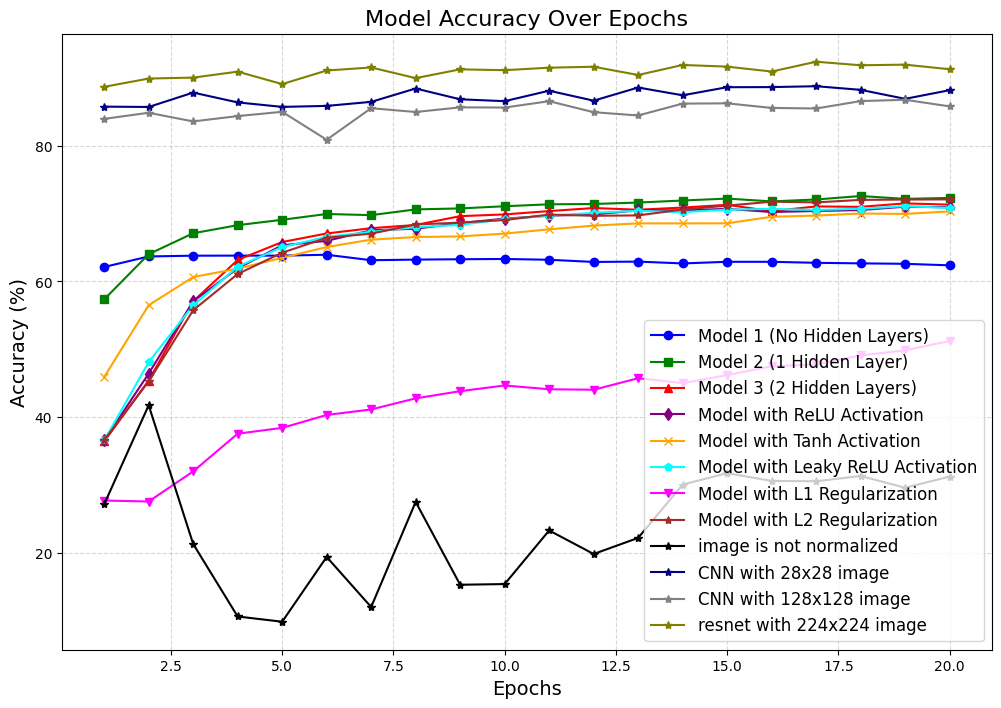

In [ ]:
import matplotlib.pyplot as plt

# Assuming accuracy arrays for all models are stored as follows:
model_1_accuracies = model_1.accuracies_Array  # Model 1 (No Hidden Layers)
model_2_accuracies = model_2.accuracies_Array  # Model 2 (1 Hidden Layer)
model_3_accuracies = model_3.accuracies_Array  # Model 3 (2 Hidden Layers)
model_relu_accuracies = model_relu.accuracies_Array  # Model with ReLU activation
model_tanh_accuracies = model_tanh.accuracies_Array  # Model with Tanh activation
model_Leaky_relu_accuracies = model_Leaky_relu.accuracies_Array  # Model with Leaky ReLU activation
model_with_l1_accuracies = model_with_l1.accuracies_Array  # Model with L1 regularization
model_with_l2_accuracies = model_with_l2.accuracies_Array  # Model with L2 regularization
model_unnormalized_image_accuracies = model_unnormalized_image.accuracies_Array
#model_128_accuracies = model_128.accuracies_Array
model_28_CNN = CNN_28_accuracy
model_128_CNN = CNN_128_accuracy
model_resnet = resnet_accuracies


# Set the number of epochs
epochs = range(1, len(model_1_accuracies) + 1)

# Plot the accuracy for each model
plt.figure(figsize=(12, 8))

plt.plot(epochs, model_1_accuracies, label="Model 1 (No Hidden Layers)", color='blue', marker='o')
plt.plot(epochs, model_2_accuracies, label="Model 2 (1 Hidden Layer)", color='green', marker='s')
plt.plot(epochs, model_3_accuracies, label="Model 3 (2 Hidden Layers)", color='red', marker='^')
plt.plot(epochs, model_relu_accuracies, label="Model with ReLU Activation", color='purple', marker='d')
plt.plot(epochs, model_tanh_accuracies, label="Model with Tanh Activation", color='orange', marker='x')
plt.plot(epochs, model_Leaky_relu_accuracies, label="Model with Leaky ReLU Activation", color='cyan', marker='p')
plt.plot(epochs, model_with_l1_accuracies, label="Model with L1 Regularization", color='magenta', marker='v')
plt.plot(epochs, model_with_l2_accuracies, label="Model with L2 Regularization", color='brown', marker='*')
plt.plot(epochs, model_unnormalized_image_accuracies, label="image is not normalized", color='black', marker='*')
#plt.plot(epochs, model_128, label="128x128 image", color='maroon', marker='*')
plt.plot(epochs, model_28_CNN, label="CNN with 28x28 image", color='navy', marker='*')
plt.plot(epochs, model_128_CNN, label="CNN with 128x128 image", color='gray', marker='*')
plt.plot(epochs, model_resnet, label="resnet with 224x224 image", color='olive', marker='*')

# Add title and labels
plt.title("Model Accuracy Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)

# Add legend
plt.legend(loc="best", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Display the plot
plt.show()


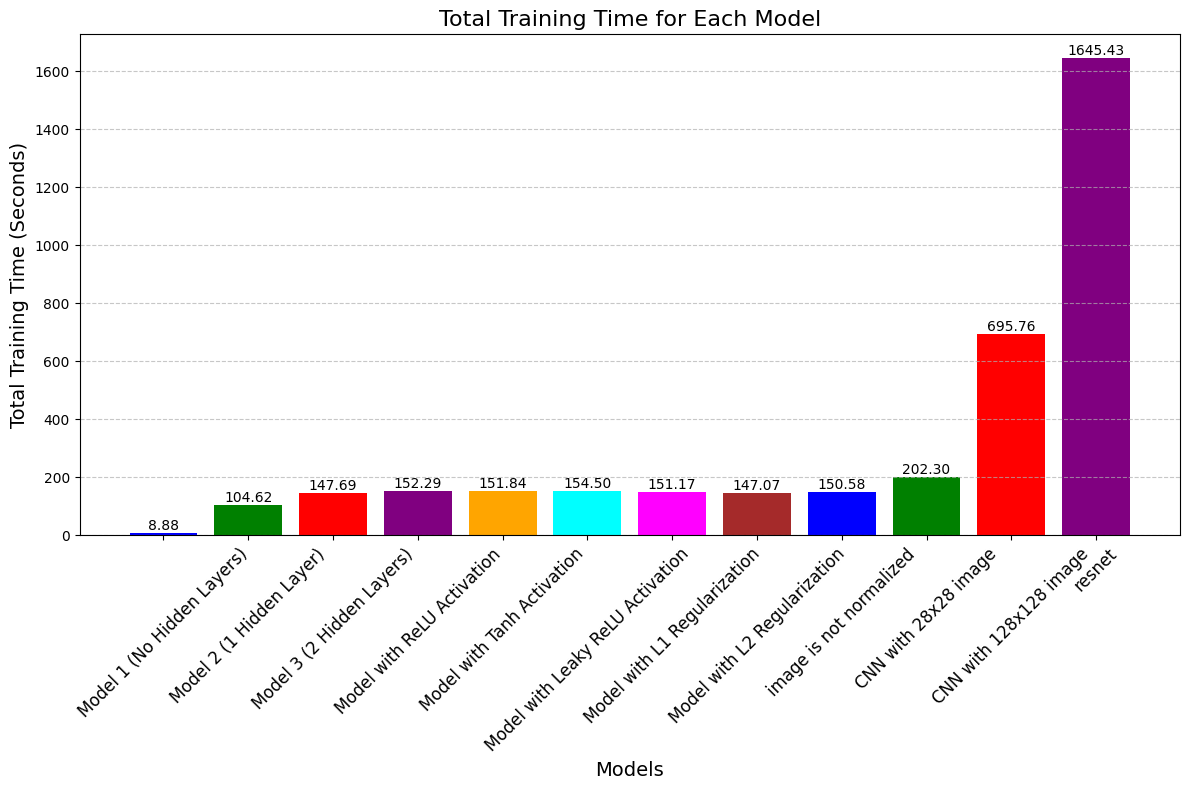

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming time arrays for all models are stored as follows:
model_1_time = model_1.time_array  # Model 1 (No Hidden Layers)
model_2_time = model_2.time_array  # Model 2 (1 Hidden Layer)
model_3_time = model_3.time_array  # Model 3 (2 Hidden Layers)
model_relu_time = model_relu.time_array  # Model with ReLU activation
model_tanh_time = model_tanh.time_array  # Model with Tanh activation
model_Leaky_relu_time = model_Leaky_relu.time_array  # Model with Leaky ReLU activation
model_with_l1_time = model_with_l1.time_array  # Model with L1 regularization
model_with_l2_time = model_with_l2.time_array  # Model with L2 regularization
model_unnormalized_image_time = model_unnormalized_image.time_array  # Model with unnormalized data
#model_128_time = model_128.time_array  # Model with 128x128 image
model_28_CNN_time = CNN_28_epoch_times
model_128_CNN_time = CNN_128_epoch_times
model_resnet_time = resnet_training_times

# Calculate the total training time for each model
total_times = {
    "Model 1 (No Hidden Layers)": np.sum(model_1_time),
    "Model 2 (1 Hidden Layer)": np.sum(model_2_time),
    "Model 3 (2 Hidden Layers)": np.sum(model_3_time),
    "Model with ReLU Activation": np.sum(model_relu_time),
    "Model with Tanh Activation": np.sum(model_tanh_time),
    "Model with Leaky ReLU Activation": np.sum(model_Leaky_relu_time),
    "Model with L1 Regularization": np.sum(model_with_l1_time),
    "Model with L2 Regularization": np.sum(model_with_l2_time),
    "image is not normalized": np.sum(model_unnormalized_image_time),
    #"Model trainied with 128x128 image": np.sum(model_128_time),
    "CNN with 28x28 image": np.sum(model_28_CNN_time),
    "CNN with 128x128 image": np.sum(model_128_CNN_time),
    "resnet": np.sum(model_resnet_time)
}

# Prepare data for the bar chart
models = list(total_times.keys())
times = list(total_times.values())

# Plot the bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(models, times, color=['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'brown'])

# Add value labels on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Add title and labels
plt.title("Total Training Time for Each Model", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Total Training Time (Seconds)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
